# Assignment 4: Building a catalog

## How to use this notebook:
The notebook is broken down into five exercises.  Within each exercise are explanatory
sections of text, and code. Sections that require a response will begin with: **Question:** 
and an empty box will follow.  Sometimes these will require a textual response, sometimes
code will be required.

## Outline:
In this assignment you will apply your knowledge to generate your own catalog of earthquakes
in a region you are interested in. You should pick somewhere that has a moderate amount of
seismicity (at least 10 earthquakes per day in the GeoNet catalog), and pick a subnetwork
of five GeoNet stations to use for your analysis. You should aim to do better than GeoNet, and
you should make a comparison of your work to their detections, picks and locations.

Finally you will consider extended sources and slip parameters.

## Deadlines:
Friday 22nd of June at 5pm by [email](mailto:calum.chamberlain@vuw.ac.nz).

## Grading:
This assignment is worth more than the previous assignments and will require more work. Give yourself
some time and work through the sections as we go through the notebooks in class.

## Marks

| Section | Marks available |
|---|---|
| Detection | 5 |
| Picking | 6 |
| Location | 5 |
| Magnitudes | 6 |
| Slip Parameters | 6 |
| Extended Sources | 7 |
| **Total** | **35** |

# Earthquake detection

Pick region of interest as outlined in the outline above.
Download two days of data and save this to disk (to avoid having to download it again later).

Using an energy detection method of your choosing and a network coincidence trigger, detect
earthquakes within these data. You should use the function implemented in [obspy](https://docs.obspy.org/tutorial/code_snippets/trigger_tutorial.html). Experiment with different
parameters and justify your final choice.  Make sure that you are detecting the seismicity you are
interested in (e.g. local earthquakes).

Compare your detections to those made by GeoNet.

In [1]:
# Answer
# Set-up, collect data and write to disk.
%matplotlib notebook
import matplotlib.pyplot as plt
plt.style.use('ggplot')

import os
from obspy import UTCDateTime, Stream, Inventory
from obspy.clients.fdsn import Client

# Selections made for a M5.5 mainshock and aftershocks in Fiordland
client = Client("GEONET")
startdate = starttime=UTCDateTime(2019, 8, 12)
enddate = startdate + 2 * 86400
station_list = {"MSZ", "WKZ", "JCZ", "MLZ", "DCZ"}
geonet_catalog_filename = "FiordlandM5_2019.xml"
waveform_filename = "Fiordland_waveforms.ms"

In [2]:
# Download data - only run this cell if re-starting from scratch.

# Download the geonet catalog
geonet_cat = client.get_events(
    starttime=startdate, endtime=enddate,
    minlatitude=-45, maxlatitude=-44,
    minlongitude=167.2, maxlongitude=168.2)
print(f"GeoNet has {len(geonet_cat)} events")
geonet_cat.write(geonet_catalog_filename, format="QUAKEML")

# Download some data and save to disk
st = Stream()
for station in station_list:
    st += client.get_waveforms(
        network="NZ", station=station, channel="HH?", location="*",
        starttime=startdate, endtime=enddate)
st.write(waveform_filename, format="MSEED")

# Download the inventory and save it to disk
bulk = []
for station in station_list:
    bulk.append(("NZ", station, "*", "HH?", startdate, enddate))
inv = client.get_stations_bulk(bulk, level="response")
inv.write("GeoNet_inventory.xml", format="STATIONXML")

GeoNet has 70 events


In [3]:
# Do the detections
from obspy import read
from obspy.signal.trigger import coincidence_trigger

st = read(waveform_filename)

# Looking for local earthquakes, so removing low frequencies
st.filter("highpass", freq=2, corners=2)
# Triggering on just the vertical channel for simplicity and to avoid duplicate detections
st2 = st.select(component="Z")

# Triggering with a fairly low threshold, lta that is much longer than P or S wave, and sta designed to capture P-wave
trig = coincidence_trigger(
    "recstalta", thr_on=4.0, thr_off=1, 
    stream=st2, thr_coincidence_sum=3, sta=0.5, lta=10)
print("Found {0} triggers".format(len(trig)))

Found 97 triggers


In [4]:
# Plotting detections to manually check that the threshold seems okay and isn't detecting noise. 

def extract_detections(st, detection_times, pre_detection=10, post_detection=100):
    detections = []
    for detection in detection_times:
        detections.append(
            st.slice(detection - pre_detection, 
                     detection + post_detection).copy())
    return detections

detections = extract_detections(st2, [t['time'] for t in trig])
# for detection in detections:  # Commented out for speed - use this to look at your detections.
#     fig = detection.plot(equal_scale=False)

There are clearly some duplicate detections in there, which is a consistent problem with earthquake detection! Nevertheless, everything looks like an earthquake. I have a similar number of detections to GeoNet, but we are using fewer stations. These detections are likely not limited to happening in the same place as GeoNet's events though. Without doing a full location for all events it is very hard to compare directly.

# Earthquake phase picking

Using the seismic_picker function, pick as many P and S phases for your **best 20** events as you can.
Remember that accuracy is more important than total number of picks. Note that if you do not have
20 detections you should either choose another region, or download more data.  You can use more than
20 events, but it will mean more work later on as well.

Include plots of your picked events in your answer.

Compare your picks to those made by GeoNet when you events that are the same. Justify
why yours are different.

In [5]:
# Answer
# Selecting detections based on maximum amplitude on JCZ above 2 Hz
detections = extract_detections(st, [t['time'] for t in trig])
detection_amplitudes = [
    (d, d.select(station="JCZ", component="Z")[0].filter(
        "highpass", freq=2, corners=2).data.max()) for d in detections]
# Sort based on maximum amplitude
detection_amplitudes.sort(key=lambda d: d[1])

# Take the largest 20 events
n_events = 2  # Using 2 for testing - set to 20 for your run.
selected_detections = [d[0] for d in detection_amplitudes[-n_events:]]

In [6]:
import os

# I will write my picks to this directory
event_directory = "Events"
if not os.path.isdir(event_directory):
    os.makedirs(event_directory)
# Write waveforms
for detected_stream in selected_detections:
    detection_time = detected_stream[0].stats.starttime.strftime("%Y-%m-%dT%H-%M-%S")
    detected_stream.write(f"{event_directory}/{detection_time}.ms", format="MSEED")

/home/calumch/miniconda3/envs/gphs445/lib/python3.7/site-packages/obspy/io/mseed/core.py:790: UserWarning: The encoding specified in trace.stats.mseed.encoding does not match the dtype of the data.
A suitable encoding will be chosen.
  warnings.warn(msg, UserWarning)


# BUG

There is an issue in the notebooks that means that interactive plots sometimes hang the notebook.

Copy and paste the following code into a python terminal (open one by opening a terminal/command prompt, starting your gphs445 environment and changing to this directory - the directory is given as output to the cell below.)

```python
import glob
from obspy import read
from utilities.seismic_picker import SeismicPicker

waveforms = glob.glob("Events/*.ms")  
# This will find all the miniseed files in the events directory that you wrote in the cell above
for waveform_file in waveforms:
    st = read(waveform_file)
    picked_event = SeismicPicker(st).pick()
    picked_event.write(waveform_file.split(".ms")[0] + "_picked.xml", format="QUAKEML")
```

In [7]:
print(f"You are running this notebook from: {os.getcwd()}")

You are running this notebook from: /home/calumch/Dropbox/Teaching/GPHS445/GPHS445_notebooks/4_Building_a_catalog


In [13]:
import glob
from obspy import read_events, Catalog

event_files = glob.glob(f"{event_directory}/*_picked.xml")
picked_events = Catalog()
for event_file in event_files:
    picked_events += read_events(event_file)
print(f"Picked events contains {len(picked_events)} events.")

Picked events contains 2 events.


# Earthquake location

Use *Hypocentre* to calculate hypocentre locations for your events as demonstrated in the 
[location notebook](3_Earthquake_Location.ipynb).

Plot the resulting locations.

Compare your locations to GeoNet locations and discuss the differences and reasons for the
differences.

Event:	2019-08-12T10:35:28.000000Z | -44.444, +167.871

	 resource_id: ResourceIdentifier(id="smi:local/1f7d88f8-bdaf-48d6-91aa-86199f331761")
	        ---------
	       picks: 7 Elements
	     origins: 1 Elements
Event:	2019-08-12T10:35:29.600000Z | -44.476, +167.813

	 resource_id: ResourceIdentifier(id="smi:local/731e6d4f-bfb0-469a-8674-a393913c4966")
	        ---------
	       picks: 5 Elements
	     origins: 1 Elements


<IPython.core.display.Javascript object>


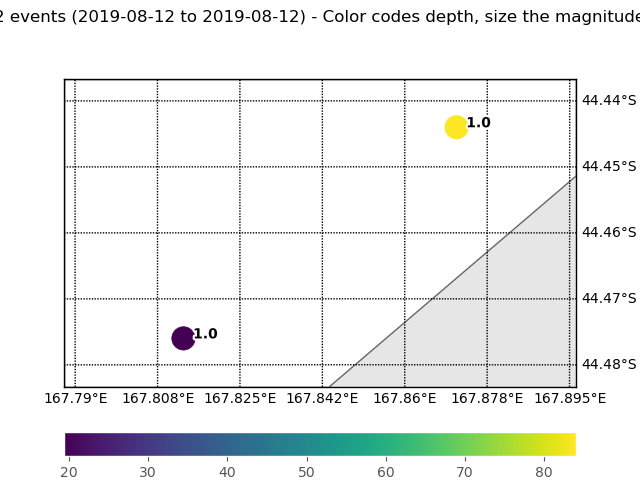

In [23]:
import glob
from obspy import read_events, Catalog, read_inventory
from utilities.geiger_inversion import seisan_hyp

# We need a velocity model - 1D with velocity in km/s and layer top in km - you should set your own model!
# Need to mark the moho
velocities = [
    {"velocity": 6.2, "top": 0.0},
    {"velocity": 6.6, "top": 12.0},
    {"velocity": 7.1, "top": 23.0},
    {"velocity": 8.05, "top": 31.0, "moho": True},
    {"velocity": 8.25, "top": 50.0},
    {"velocity": 8.5, "top": 80.0}]

located_cat = Catalog()
inventory = read_inventory("GeoNet_inventory.xml")
# We will read the picked files from disk again
event_files = glob.glob(f"{event_directory}/*_picked.xml")
for event_file in event_files:
    event = read_events(event_file)[0]
    event_located = seisan_hyp(event, inventory, velocities, vpvs=1.74)
    event_located.picks = event.picks
    event_located.write(event_file.split("_picked.xml")[0] + "_located.xml", format="QUAKEML")
    located_cat += event_located
    print(event_located)

# Fix magnitudes - won't plot without
from obspy.core.event import Magnitude
for ev in located_cat:
    ev.magnitudes.append(Magnitude(mag=1))
fig = located_cat.plot(projection="local")

<IPython.core.display.Javascript object>


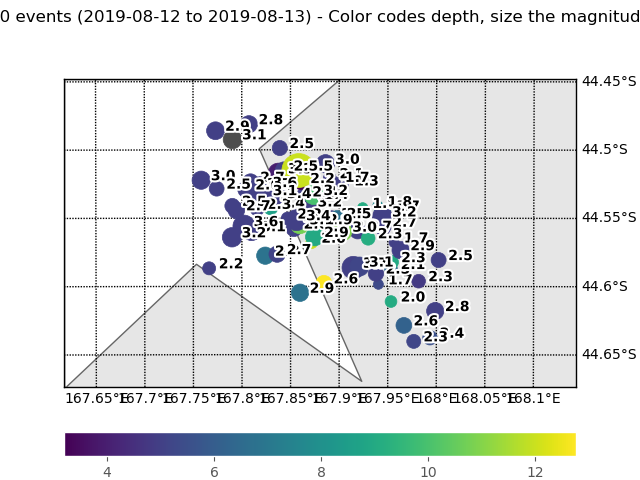

In [19]:
geonet_cat = read_events(geonet_catalog_filename)
fig = geonet_cat.plot(projection="local")

# Magnitudes

Using the picking functions in the [magnitude notebook](4_Magnitudes.ipynb), compute local
magnitude and coda magnitudes for your events.

Compare your magnitudes to each other and discuss the differences - make a plot of local magnitude
against coda magnitude.

Compare you magnitudes to GeoNet magnitudes and discuss the difference.

# BUG

Because we are using the same function as the picking used - the same bug as before holds.

If you have followed through as above then you can add picks to the events you have already picked by
copy and pasting the following code into a python terminal (open one by opening a terminal/command prompt, starting your gphs445 environment and changing to this directory - the directory is given as output to the cell above, as it was before.)

```python
import glob
from obspy import read, read_events, read_inventory
from utilities.seismic_picker import SeismicPicker

paz_WA = {'poles': [-6.283 + 4.7124j, -6.283 - 4.7124j],
          'zeros': [0 + 0j], 'gain': 1.0, 'sensitivity': 2080}

inv = read_inventory("GeoNet_inventory.xml")
waveforms = glob.glob("Events/*.ms") 
# This will find all the miniseed files in the events directory that you wrote in the cell above
for waveform_file in waveforms:
    st = read(waveform_file)
    st_wa = st.copy()
    st_wa = st_wa.remove_response(inv, "DISP")
    st_wa = st_wa.simulate(paz_remove=None, paz_simulate=paz_WA)
    event = read_events(waveform_file.split(".ms")[0] + "_located.xml")[0]
    picked_event = SeismicPicker(st_wa, event_in=event).pick()
    picked_event.write(waveform_file.split(".ms")[0] + "_magnitude.xml", format="QUAKEML")
```

In [24]:
# Read the events back in:
event_files = glob.glob(f"{event_directory}/*_magnitude.xml")
magnitude_picked_events = Catalog()
for event_file in event_files:
    magnitude_picked_events += read_events(event_file)
print(f"Picked events contains {len(magnitude_picked_events)} events.")

Picked events contains 2 events.


In [28]:
# Compute local magnitude
from utilities.coordinates import Geographic
from math import log10

def _distance(point_1, point_2):
    """
    Calcuate hypocentral distance from Geographic points
    
    :type point_1: `coordinates.Geographic`
    :type point_2: `coordinates.Geographic`
    
    :returns: float
    """
    point_2_xyz = point_2.to_xyz(origin=point_1, strike=0, dip=90)
    return (point_2_xyz.x ** 2 + point_2_xyz.y ** 2 + point_2_xyz.z ** 2) ** 0.5


def compute_richter(event, inv):
    origin = event.preferred_origin() or event.origins[-1]
    origin = Geographic(
        latitude=origin.latitude, longitude=origin.longitude, 
        depth=origin.depth / 1000.)
    magnitude = 0
    used_station_count = 0
    for amplitude in event.amplitudes:
        if amplitude.type == 'END':
            continue
        pick = amplitude.pick_id.get_referred_object()
        station_loc = inv.get_coordinates(pick.waveform_id.get_seed_string(),
                                          pick.time)
        station_loc = Geographic(
            latitude=station_loc["latitude"], longitude=station_loc["longitude"],
            depth=(station_loc["local_depth"] - station_loc["elevation"]) / 1000.)
        distance = _distance(origin, station_loc)
        print("Amplitude {0:.2g} m at {1:.2f} km".format(
            amplitude.generic_amplitude, distance))
        station_magnitude = (
            log10(amplitude.generic_amplitude * 1e6) + log10(distance) - 
            0.0029 * distance + 0)
        print("Using the Richter scale gives: {0:.2f}".format(station_magnitude))
        magnitude += station_magnitude
        used_station_count += 1

    if used_station_count == 0:
        print("No usable amplitude picks")
        return event
    magnitude /= used_station_count
    print("Average magnitude: {0:.2f}".format(magnitude))
    event.magnitudes.append(Magnitude(mag=magnitude, magnitude_type="ML"))
    return event


def compute_duration(event, inv):
    origin = event.preferred_origin() or event.origins[-1]
    origin = Geographic(
        latitude=origin.latitude, longitude=origin.longitude, 
        depth=origin.depth / 1000.)
    magnitude = 0
    used_station_count = 0
    for amplitude in event.amplitudes:
        if amplitude.type != 'END':
            continue
        pick = amplitude.pick_id.get_referred_object()
        station_loc = inv.get_coordinates(pick.waveform_id.get_seed_string(),
                                          pick.time)
        station_loc = Geographic(
            latitude=station_loc["latitude"], longitude=station_loc["longitude"],
            depth=(station_loc["local_depth"] - station_loc["elevation"]) / 1000.)
        distance = _distance(origin, station_loc)
        print("Duration {0:.2g} s at {1:.2f} km".format(
            amplitude.generic_amplitude, distance))
        station_magnitude = (
            2.4 * log10(amplitude.generic_amplitude) + 0.00046 * distance - 1.59)
        print("Using the Mexican Md scale gives: {0}".format(station_magnitude))
        magnitude += station_magnitude
        used_station_count += 1
    if used_station_count == 0:
        print("No usable duration picks")
        return event
    magnitude /= used_station_count
    print("Average magnitude: {0}".format(magnitude))
    event.magnitudes.append(Magnitude(mag=magnitude, magnitude_type="MD"))
    return event

    
magnitude_cat = Catalog()
for event in magnitude_picked_events:
    event = compute_richter(event, inventory)
    event = compute_duration(event, inventory)
    magnitude_cat.append(event)

Amplitude 0.0067 m at 123.11 km
Using the Richter scale gives: 5.56
Average magnitude: 5.56
Duration 67 s at 123.11 km
Using the Mexican Md scale gives: 2.8429900943254696
Average magnitude: 2.8429900943254696
Amplitude 0.027 m at 119.33 km
Using the Richter scale gives: 6.16
Average magnitude: 6.16
No usable duration picks


In [ ]:
# TODO: Plot magnitudes.

# Slip parameters

Write a function that accepts as input the strike, dip, and rake 
of a double-couple earthquake source and does the following:
1. Computes the normal and slip vectors with respect to geographic coordinates;
2. Computes the P, T, and B axes using appropriate addition/subtraction/cross
   product operations on the normal and slip vectors;

*Removed for 2020 due to COVID*

~~3. Constructs the moment tensor with respect to geographic coordinates;~~

~~4. Diagonalises the moment tensor with respect to the principal axes P, B, and T obtained by eigen-analysis.~~

Apply your function to three focal mechanisms of your choice, preferably from near your
area of interest, and ideally representing normal, strike-slip, and reverse faulting. 
You can find moment tensor solutions for geonet events [here](https://github.com/GeoNet/data/blob/master/moment-tensor/GeoNet_CMT_solutions.csv) which
have best fit double-couple solutions given for them.

# Extended sources

Problems 8, 9, 14, 17, ~~19~~ of Stein and Wysession Chpt. 4 - you can submit these separately on
paper if you wish. *19 removed for 2020 due to COVID*